<a href="https://colab.research.google.com/github/mateusnobre/projects_personal_-_professional/blob/master/COVID-19%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#imports
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
from google.colab import drive
drive.mount('/content/gdrive' , force_remount = True)
#drive.flush_and_unmount()


Mounted at /content/gdrive


In [0]:
def get_dates (city_data, init_date, n_cut = None, cut = False):
    """
    Process dates and turn them into datetime's objects
    
    :param city_data: City data
    :type city_data: Pandas Dataframe
    :param init_date: initial date data 
    :type init_date: Pandas Dataframe
    :param n_cut: tuple that determine how many points will be cuted from the beginning and the end, respectively
    :type n_cut: int's tuple
    :param cut: True if we choose to cut elements from the end or beginning
    :type cut: bool
    :return dates: list of dates
    :rtype dates: list of datetime objects
    """    
    init_day, init_month, init_year = init_date.loc['day'], init_date.loc['month'], init_date.loc['year']
    initial = datetime.date(init_year, init_month, init_day)
    dates = [(initial + city_data['day'][i] * datetime.timedelta(days = 1)) for i in range(len(city_data['case']))] 
    if cut == True:
      if(n_cut[1] != 0):
        dates = dates[n_cut[0]:-(n_cut[1])]
      else:
        dates = dates[n_cut[0]:]
    return dates

def get_predicted_results(city_data, n_cut = None, cut = False):
    """
    Predict results using linear regression and returns some statistics

    :param city_data: City data
    :type city_data: Pandas Dataframe
    :param n_cut: Tuple that determine how many points will be cuted from the beginning and the end, respectively
    :type n_cut: int's tuple
    :param cut: True if we choose to cut elements from the end or beginning
    :type cut: bool
    :return predicted: Predicted results using linear regression
    :rtype predicted: Pandas Series
    :return log_cases:Log of number of cases 
    :rtype log_cases: Pandas Series
    :return abs_residuals: Difference between predicted and actual results
    :rtype abs_residuals: Pandas Series
    :return ang_coeff: Slope
    :rtype ang_coeff: float
    :return lin_coeff: Intercept
    :rtype lin_coeff: float
    :return r_value: R-value
    :rtype r_value: float
    :return p_value: p-value
    :rtype p_value: float
    """  
    if cut == True:
      if(n_cut[1] != 0):
        city_data = city_data[n_cut[0]:-(n_cut[1])]
      else:
        print('cheguei')
        city_data = city_data[n_cut[0]:]
    log_cases = np.log(city_data['case'])
    X = city_data['day']
    y = log_cases
    ang_coeff, lin_coeff, r_value, p_value, std_err = linregress(X,y)
    predicted = ang_coeff * city_data['day']
    predicted += lin_coeff
    abs_residuals = predicted - log_cases
    return predicted, log_cases, abs_residuals, ang_coeff, lin_coeff, r_value, p_value

def plot_results (dates, predicted, log_cases, abs_residuals, city_name, r_value, p_value):
    """
    Plot predicted and actual data

    :param dates: list of dates
    :type dates: list of datetime objects
    :param predicted: Predicted results using linear regression
    :type predicted: Pandas Series
    :param log_cases:Log of number of cases 
    :type log_cases: Pandas Series
    :param abs_residuals: Difference between predicted and actual results
    :type abs_residuals: Pandas Series
    :param city_name: City's name
    :type city_name: string
    :param r_value: R-value
    :type r_value: float
    :param p_value: p-value
    :type p_value: float   
    """
    # Configura formato amigável para apresentação das datas
    months = mdates.MonthLocator()  # every month
    weeks = mdates.WeekdayLocator()  # every week
    days = mdates.DayLocator()  # every day
    month_fmt = mdates.DateFormatter('%d/%b')  # day month
 
    _, ax = plt.subplots()
    plt.title(u'Ajuste log(Casos notificados) x tempo (dias). Cidade: ' + city_name)
    plt.plot(dates, log_cases, 'o')
    plt.plot(dates, predicted, '-')
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(month_fmt)
    plt.xlabel('tempo(dias), r2 : {:.3f}. p-value {:.3f}'.format(r_value ** 2, p_value) )
    plt.ylabel(u'log(Notificação)')

    _, ax = plt.subplots()
    plt.title(u'Gráfico de resíduos. Cidade: ' + city_name)
    plt.plot(dates, abs_residuals, 'o')
    plt.axhline(0)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(month_fmt)
    plt.xlabel(u'tempo(dias)')
    plt.ylabel(u'Resíduos absolutos')

    plt.show()
    return 0
    
def process_city_data(city_name, n_cut = None, cut = False):
    """
    Read city data and plot results

    :param city_name: city's name
    :type city_name: string
    :param n_cut: tuple that determine how many points will be cuted from the beginning and the end, respectively
    :type n_cut: int's tuple
    :param cut: True if we choose to cut elements from the end or beginning
    :type cut: bool
    """
    if n_cut[0] != 0 or n_cut[1] != 0:
      cut = True
    input_data_file = '/content/gdrive/My Drive/Classroom/lab_fis26_2020_1/analise_dados_aula1/'+ city_name + '_data.csv'
    input_init_file = '/content/gdrive/My Drive/Classroom/lab_fis26_2020_1/analise_dados_aula1/data_init_' + city_name + '.txt'

    city = pd.read_csv(input_data_file)
    init_date = pd.read_csv(input_init_file, sep = '\t', index_col= 0, header = None)
    dates = get_dates(city, init_date, n_cut, cut)
    predicted, log_cases, abs_residuals, ang_coeff, lin_coeff, r_value, p_value = get_predicted_results(city, n_cut, cut)
    plot_results(dates, predicted, log_cases, abs_residuals, city_name, r_value, p_value)
    
    # Calculate doubling time and its uncertainty
    m_cov = np.cov(city['case'])
    doubling_time = np.log(2) / ang_coeff
    dt_uncertainty = np.log(2) / (np.square(ang_coeff) * np.sqrt(m_cov))
    print(u'doubling_time = %.2f dias / uncertainty = %.2f dias' % (doubling_time, dt_uncertainty))
    return None
  

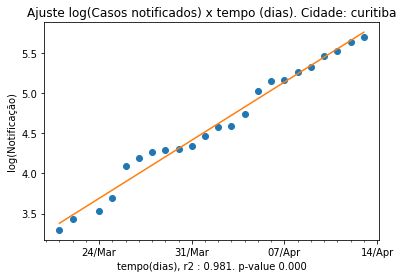

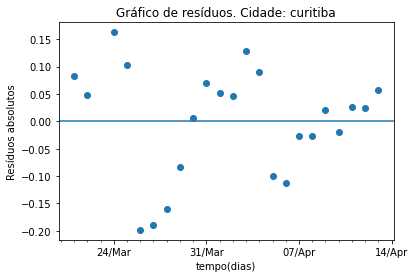

doubling_time = 6.70 dias / uncertainty = 0.53 dias


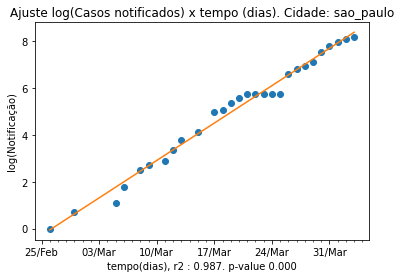

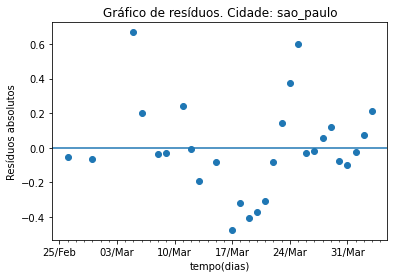

doubling_time = 3.04 dias / uncertainty = 0.01 dias


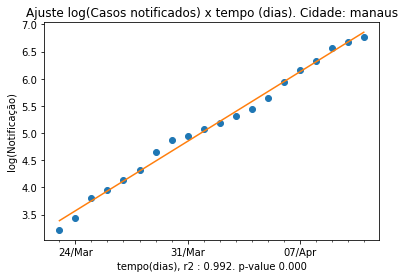

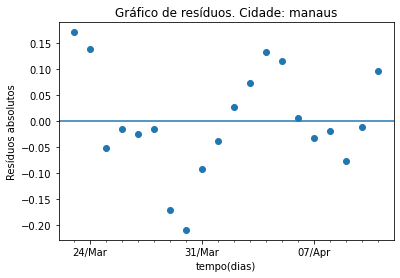

doubling_time = 3.80 dias / uncertainty = 0.03 dias


In [16]:
chosen_cities = ['curitiba', 'sao_paulo','manaus']
n_cuts = [[4, 8], [0, 2], [4, 11]]
for city, n_cut in zip(chosen_cities, n_cuts):
  process_city_data(city, n_cut)